IMPORTS


In [1]:
from IPython.display import clear_output
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import skimage.io
import skimage.color
import skimage.transform
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
import torchvision.transforms as T
from PIL import Image
import scipy.ndimage as ndimage
from tqdm import tqdm
import random
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
import kagglehub
briscdataset_brisc2025_path = kagglehub.dataset_download('briscdataset/brisc2025')
print('Data source import complete.')

Using Colab cache for faster access to the 'brisc2025' dataset.
Data source import complete.


In [ ]:
base_seg_path = "/kaggle/input/brisc2025/brisc2025/segmentation_task"
base_cls_path = "/kaggle/input/brisc2025/brisc2025/classification_task"

seg_train_img = os.path.join(base_seg_path, "train/images")
seg_train_mask = os.path.join(base_seg_path, "train/masks")
seg_test_img = os.path.join(base_seg_path, "test/images")
seg_test_mask = os.path.join(base_seg_path, "test/masks")

cls_train_dir = os.path.join(base_cls_path, "train")
cls_test_dir = os.path.join(base_cls_path, "test")


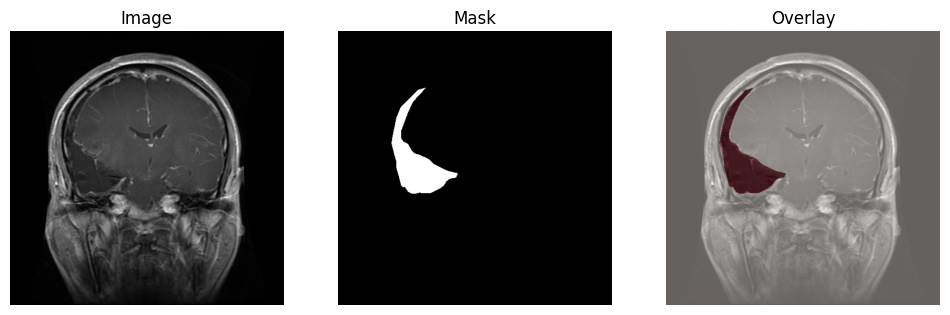

In [ ]:
rand_file = random.choice(os.listdir(seg_train_img))
img_path = os.path.join(seg_train_img, rand_file)
mask_path = os.path.join(seg_train_mask, rand_file.replace(".jpg", ".png"))

img = Image.open(img_path).convert("RGB")
mask = Image.open(mask_path).convert("L")

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img)
plt.imshow(mask, cmap="Reds", alpha=0.4)
plt.title("Overlay")
plt.axis("off")

plt.show()

In [ ]:
tumor_names = {0: "Glioma", 1: "Meningioma", 2: "Pituitary", 3: "No Tumor"}

Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


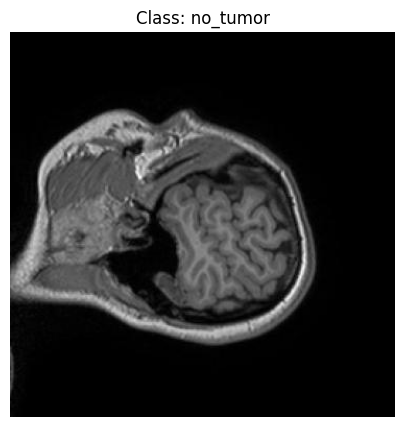

In [ ]:
cls_train_root = os.path.join(base_cls_path, "train")
cls_test_root  = os.path.join(base_cls_path, "test")

# List class folders
classes = sorted(os.listdir(cls_train_root))
print("Classes:", classes)

# Pick random class
rand_class = random.choice(classes)
class_dir = os.path.join(cls_train_root, rand_class)

# Pick random image from that class
rand_file = random.choice(os.listdir(class_dir))
img_path = os.path.join(class_dir, rand_file)

# Load image
img = Image.open(img_path).convert("RGB")

# Show
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title(f"Class: {rand_class}")
plt.axis("off")
plt.show()

DATA PREPOSSECING: For Data Pre-processtion we have tried CLAHE , AUGMENTATION AND Z Normalization but for these preposceesing models for 10 epochs, lr=0.0005 and batch_size=8 we got 0.45 , 0.34 and 0.67 IoU values respectively, and willjust resizing the images we got IoU value of 0.68 for the same hyperameters. Hence we have used opted resizing the images instead of other methods.

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, size=(256, 256), transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(img_dir))
        self.transform = transform or T.Compose([
            T.Grayscale(),
            T.Resize(size),
            T.ToTensor(),
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".jpg", ".png"))
        image = self.transform(Image.open(img_path))
        mask = self.transform(Image.open(mask_path))
        return image, mask

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, root_dir, size=(256, 256), transform=None):
        self.root_dir = root_dir
        self.transform = transform or T.Compose([
            T.Grayscale(),
            T.Resize(size),
            T.ToTensor(),
        ])
        self.images = []
        self.labels = []
        for label, class_dir in enumerate(sorted(os.listdir(root_dir))):
            class_path = os.path.join(root_dir, class_dir)
            for img_file in os.listdir(class_path):
                if img_file.endswith('.jpg'):
                    self.images.append(os.path.join(class_path, img_file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = self.transform(Image.open(img_path))
        label = self.labels[idx]
        return image, label

In [ ]:
class BatchLoader:
    def __init__(self, dataset, batch_size=16, shuffle=True, device='cpu', task='segmentation'):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.device = device
        self.task = task
        self.indices = np.arange(len(dataset))
        self.len = int(np.ceil(len(dataset) / batch_size))
        if shuffle:
            np.random.shuffle(self.indices)
        self.iter = 0

    def __iter__(self):
        self.iter = 0
        if self.shuffle:
            np.random.shuffle(self.indices)
        return self

    def __next__(self):
        if self.iter >= self.len:
            raise StopIteration

        start = self.iter * self.batch_size
        idx = self.indices[start:start + self.batch_size]
        self.iter += 1

        batch = [self.dataset[i] for i in idx]
        if self.task == 'classification':
            batch_x = torch.stack([x for x, _ in batch])
            batch_y = torch.tensor([y for _, y in batch], dtype=torch.long)
            if batch_y.max() >= 4 or batch_y.min() < 0:
                raise ValueError(f"Invalid labels in batch: {batch_y}")
            assert batch_x.shape == (len(idx), 1, 256, 256), f"Unexpected input shape: {batch_x.shape}"
            assert batch_y.shape == (len(idx),), f"Unexpected label shape: {batch_y.shape}"
            return batch_x.to(self.device), batch_y.to(self.device)
        elif self.task == 'segmentation':
            batch_x = torch.stack([x for x, _ in batch])
            batch_y = torch.stack([y for _, y in batch])
            assert batch_x.shape == (len(idx), 1, 256, 256), f"Unexpected input shape: {batch_x.shape}"
            assert batch_y.shape == (len(idx), 1, 256, 256), f"Unexpected mask shape: {batch_y.shape}"
            return batch_x.to(self.device), batch_y.to(self.device)
        elif self.task == 'both':
            batch_x = torch.stack([x for x, _, _ in batch])
            batch_y_label = torch.tensor([y_label for _, y_label, _ in batch], dtype=torch.long)
            batch_y_mask = torch.stack([y_mask for _, _, y_mask in batch])
            if batch_y_label.max() >= 4 or batch_y_label.min() < 0:
                raise ValueError(f"Invalid labels in batch: {batch_y_label}")
            assert batch_x.shape == (len(idx), 1, 256, 256), f"Unexpected input shape: {batch_x.shape}"
            assert batch_y_label.shape == (len(idx),), f"Unexpected label shape: {batch_y_label.shape}"
            assert batch_y_mask.shape == (len(idx), 1, 256, 256), f"Unexpected mask shape: {batch_y_mask.shape}"
            return batch_x.to(self.device), batch_y_label.to(self.device), batch_y_mask.to(self.device)

    def next(self, task=None):
        return self.__next__()

    def __len__(self):
        return self.len

CREATING MODELS:

U-NET


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        skip = self.conv(x)
        return self.pool(skip), skip

In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels * 2, out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

In [ ]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x):
        return self.conv(x)


In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=1):
        super().__init__()
        self.encoder1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = Bottleneck(512, 1024)
        self.decoder1 = Decoder(1024, 512)
        self.decoder2 = Decoder(512, 256)
        self.decoder3 = Decoder(256, 128)
        self.decoder4 = Decoder(128, 64)
        self.output_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        skip1 = self.encoder1(x)
        x = self.pool1(skip1)
        skip2 = self.encoder2(x)
        x = self.pool2(skip2)
        skip3 = self.encoder3(x)
        x = self.pool3(skip3)
        skip4 = self.encoder4(x)
        x = self.pool4(skip4)
        b = self.bottleneck(x)
        d1 = self.decoder1(b, skip4)
        d2 = self.decoder2(d1, skip3)
        d3 = self.decoder3(d2, skip2)
        d4 = self.decoder4(d3, skip1)
        out = self.output_conv(d4)
        return out

ATTACHING CLASSIFER HEAD

In [ ]:
class UNetEncoder(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.encoder1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = Bottleneck(512, 1024)

    def forward(self, x):
        x = self.encoder1(x)
        x = self.pool1(x)
        x = self.encoder2(x)
        x = self.pool2(x)
        x = self.encoder3(x)
        x = self.pool3(x)
        x = self.encoder4(x)
        x = self.pool4(x)
        b = self.bottleneck(x)
        return b



In [ ]:
class Classifier(nn.Module):
    def __init__(self, in_channels=1, num_classes=4):
        super().__init__()
        self.encoder = UNetEncoder(in_channels)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        b = self.encoder(x)
        p = self.pool(b).squeeze(-1).squeeze(-1)
        out = self.fc(p)
        return out

ATTENTION U-NET

In [ ]:
class AttentionGate(nn.Module):
    def __init__(self, g_channels, x_channels, inter_channels):
        super().__init__()
        self.Wg = nn.Conv2d(g_channels, inter_channels, kernel_size=1, stride=1)
        self.Wx = nn.Conv2d(x_channels, inter_channels, kernel_size=1, stride=1)
        self.psi = nn.Conv2d(inter_channels, 1, kernel_size=1, stride=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    def forward(self, g, x):
        if x.size()[2:] != g.size()[2:]:
            x_down = F.interpolate(x, size=g.size()[2:], mode='bilinear', align_corners=True)
        else:
            x_down = x
        wg = self.Wg(g)
        wx = self.Wx(x_down)
        att = F.relu(wg + wx)
        att = self.psi(att)
        att = torch.sigmoid(att)
        att = self.upsample(att) if att.size()[2:] != x.size()[2:] else att
        return att * x


In [ ]:
class AttentionDecoder(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.att = AttentionGate(out_channels, skip_channels, skip_channels // 2)
        self.conv = DoubleConv(out_channels + skip_channels, out_channels)
    def forward(self, x, skip):
        x = self.upconv(x)
        att_skip = self.att(x, skip)
        x = torch.cat([x, att_skip], dim=1)
        return self.conv(x)


In [ ]:
class AttentionUNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=1):
        super().__init__()
        self.encoder1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = Bottleneck(512, 1024)
        self.decoder1 = AttentionDecoder(1024, 512, 512)
        self.decoder2 = AttentionDecoder(512, 256, 256)
        self.decoder3 = AttentionDecoder(256, 128, 128)
        self.decoder4 = AttentionDecoder(128, 64, 64)
        self.output_conv = nn.Conv2d(64, num_classes, kernel_size=1)
    def forward(self, x):
        skip1 = self.encoder1(x)
        x = self.pool1(skip1)
        skip2 = self.encoder2(x)
        x = self.pool2(skip2)
        skip3 = self.encoder3(x)
        x = self.pool3(skip3)
        skip4 = self.encoder4(x)
        x = self.pool4(skip4)
        b = self.bottleneck(x)
        d1 = self.decoder1(b, skip4)
        d2 = self.decoder2(d1, skip3)
        d3 = self.decoder3(d2, skip2)
        d4 = self.decoder4(d3, skip1)
        out = self.output_conv(d4)
        return out

DEFINING LOSS

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, epsilon=1e-6):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)
        preds = preds.view(-1)
        targets = targets.view(-1)
        intersection = (preds * targets).sum()
        sum_preds_targets = preds.sum() + targets.sum()
        if sum_preds_targets == 0:
            return torch.tensor(1.0, device=preds.device)
        dice_loss = 1 - (2. * intersection + self.epsilon) / (sum_preds_targets + self.epsilon)
        return dice_loss

In [ ]:
def calculate_iou(y_pred, y_true, threshold=0.5, eps=1e-6):
    y_pred = torch.sigmoid(y_pred)
    y_pred = (y_pred > threshold).float()
    y_pred = y_pred.view(y_pred.shape[0], -1)
    y_true = y_true.view(y_true.shape[0], -1)
    intersection = (y_pred * y_true).sum(dim=1)
    union = y_pred.sum(dim=1) + y_true.sum(dim=1) - intersection
    iou = (intersection + eps) / (union + eps)
    return iou.mean()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

img_size = (256, 256)

seg_train_dataset = SegmentationDataset(seg_train_img, seg_train_mask, size=img_size)
seg_train_loader = BatchLoader(seg_train_dataset, batch_size=16, shuffle=True, device=device, task='segmentation')
seg_test_dataset = SegmentationDataset(seg_test_img, seg_test_mask, size=img_size)
seg_test_loader = BatchLoader(seg_test_dataset, batch_size=16, shuffle=False, device=device, task='segmentation')

cls_train_dataset = ClassificationDataset(cls_train_dir, size=img_size)
cls_train_loader = BatchLoader(cls_train_dataset, batch_size=16, shuffle=True, device=device, task='classification')
cls_test_dataset = ClassificationDataset(cls_test_dir, size=img_size)
cls_test_loader = BatchLoader(cls_test_dataset, batch_size=16, shuffle=False, device=device, task='classification')


Using device: cuda


MODEL TRAINING


U-NET TRAINING


In [ ]:

model_unet = UNet(in_channels=1, num_classes=1).to(device)
optim_unet = torch.optim.AdamW(model_unet.parameters(), lr=0.0001)
dice_loss = DiceLoss()
bce_loss = nn.BCEWithLogitsLoss()

num_epochs = 25

for epoch in range(num_epochs):
    print(f"Epoch - {epoch+1}")
    model_unet.train()
    train_bce = 0.0
    train_dice = 0.0
    train_iou = 0.0

    for x, y in tqdm(seg_train_loader, desc="Training"):
        if torch.isnan(x).any() or torch.isinf(x).any() or torch.isnan(y).any() or torch.isinf(y).any():
            print("NaN/Inf detected in input or mask")
            continue
        y_pred = model_unet(x)
        if torch.isnan(y_pred).any() or torch.isinf(y_pred).any():
            print("NaN/Inf detected in predictions")
            continue
        bce = bce_loss(y_pred, y)
        dice = dice_loss(y_pred, y)
        iou = calculate_iou(y_pred, y)
        loss = 0.2 * bce + 0.8 * dice
        optim_unet.zero_grad()
        loss.backward()
        optim_unet.step()
        train_bce += bce.item()
        train_dice += dice.item()
        train_iou += iou.item()

    avg_train_bce = train_bce / len(seg_train_loader)
    avg_train_dice = train_dice / len(seg_train_loader)
    avg_train_iou = train_iou / len(seg_train_loader)

    model_unet.eval()
    test_bce = 0.0
    test_dice = 0.0
    test_iou = 0.0
    with torch.no_grad():
        for x, y in seg_test_loader:
            if torch.isnan(x).any() or torch.isinf(x).any() or torch.isnan(y).any() or torch.isinf(y).any():
                print("NaN/Inf detected in test input or mask")
                continue
            y_pred = model_unet(x)
            test_bce += bce_loss(y_pred, y).item()
            test_dice += dice_loss(y_pred, y).item()
            test_iou += calculate_iou(y_pred, y).item()

    avg_test_bce = test_bce / len(seg_test_loader)
    avg_test_dice = test_dice / len(seg_test_loader)
    avg_test_iou = test_iou / len(seg_test_loader)

    print(f"Train BCE loss - {avg_train_bce:.6f} | Train Dice loss - {avg_train_dice:.6f} | Train IoU - {avg_train_iou:.6f}")
    print(f"Test BCE loss - {avg_test_bce:.6f} | Test Dice loss - {avg_test_dice:.6f} | Test IoU - {avg_test_iou:.6f}")
    print()

torch.save(model_unet.state_dict(), 'model_unet.pth')

Epoch - 1


Training: 100%|██████████| 246/246 [04:06<00:00,  1.00s/it]


Train BCE loss - 0.366538 | Train Dice loss - 0.915617 | Train IoU - 0.342981
Test BCE loss - 0.256106 | Test Dice loss - 0.884582 | Test IoU - 0.493869

Epoch - 2


Training: 100%|██████████| 246/246 [03:30<00:00,  1.17it/s]


Train BCE loss - 0.211689 | Train Dice loss - 0.858335 | Train IoU - 0.454089
Test BCE loss - 0.166999 | Test Dice loss - 0.809906 | Test IoU - 0.500630

Epoch - 3


Training: 100%|██████████| 246/246 [03:30<00:00,  1.17it/s]


Train BCE loss - 0.126034 | Train Dice loss - 0.773764 | Train IoU - 0.521843
Test BCE loss - 0.158002 | Test Dice loss - 0.728903 | Test IoU - 0.385500

Epoch - 4


Training: 100%|██████████| 246/246 [03:30<00:00,  1.17it/s]


Train BCE loss - 0.068312 | Train Dice loss - 0.627874 | Train IoU - 0.598188
Test BCE loss - 0.054170 | Test Dice loss - 0.560066 | Test IoU - 0.621069

Epoch - 5


Training: 100%|██████████| 246/246 [03:30<00:00,  1.17it/s]


Train BCE loss - 0.044727 | Train Dice loss - 0.464966 | Train IoU - 0.641698
Test BCE loss - 0.035179 | Test Dice loss - 0.407801 | Test IoU - 0.687158

Epoch - 6


Training: 100%|██████████| 246/246 [03:30<00:00,  1.17it/s]


Train BCE loss - 0.032997 | Train Dice loss - 0.333582 | Train IoU - 0.681204
Test BCE loss - 0.032745 | Test Dice loss - 0.313460 | Test IoU - 0.668798

Epoch - 7


Training: 100%|██████████| 246/246 [03:30<00:00,  1.17it/s]


Train BCE loss - 0.028425 | Train Dice loss - 0.258123 | Train IoU - 0.701340
Test BCE loss - 0.034930 | Test Dice loss - 0.272507 | Test IoU - 0.693821

Epoch - 8


Training: 100%|██████████| 246/246 [03:30<00:00,  1.17it/s]


Train BCE loss - 0.026816 | Train Dice loss - 0.216475 | Train IoU - 0.717947
Test BCE loss - 0.036653 | Test Dice loss - 0.236829 | Test IoU - 0.685628

Epoch - 9


Training: 100%|██████████| 246/246 [03:30<00:00,  1.17it/s]


Train BCE loss - 0.026380 | Train Dice loss - 0.195133 | Train IoU - 0.716745
Test BCE loss - 0.032057 | Test Dice loss - 0.235793 | Test IoU - 0.694861

Epoch - 10


Training: 100%|██████████| 246/246 [03:31<00:00,  1.16it/s]


Train BCE loss - 0.023933 | Train Dice loss - 0.166492 | Train IoU - 0.741980
Test BCE loss - 0.030612 | Test Dice loss - 0.203051 | Test IoU - 0.716622

Epoch - 11


Training: 100%|██████████| 246/246 [03:31<00:00,  1.17it/s]


Train BCE loss - 0.023547 | Train Dice loss - 0.155750 | Train IoU - 0.748960
Test BCE loss - 0.035711 | Test Dice loss - 0.208345 | Test IoU - 0.690817

Epoch - 12


Training: 100%|██████████| 246/246 [03:30<00:00,  1.17it/s]


Train BCE loss - 0.022820 | Train Dice loss - 0.145773 | Train IoU - 0.752959
Test BCE loss - 0.033582 | Test Dice loss - 0.172132 | Test IoU - 0.721139

Epoch - 13


Training: 100%|██████████| 246/246 [03:30<00:00,  1.17it/s]


Train BCE loss - 0.022829 | Train Dice loss - 0.140774 | Train IoU - 0.753225
Test BCE loss - 0.030745 | Test Dice loss - 0.171488 | Test IoU - 0.721406

Epoch - 14


Training: 100%|██████████| 246/246 [03:30<00:00,  1.17it/s]


Train BCE loss - 0.021658 | Train Dice loss - 0.130329 | Train IoU - 0.763545
Test BCE loss - 0.027902 | Test Dice loss - 0.167401 | Test IoU - 0.724085

Epoch - 15


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.021696 | Train Dice loss - 0.125590 | Train IoU - 0.767017
Test BCE loss - 0.030450 | Test Dice loss - 0.157453 | Test IoU - 0.730336

Epoch - 16


Training: 100%|██████████| 246/246 [03:30<00:00,  1.17it/s]


Train BCE loss - 0.020029 | Train Dice loss - 0.115710 | Train IoU - 0.777898
Test BCE loss - 0.029330 | Test Dice loss - 0.148538 | Test IoU - 0.743380

Epoch - 17


Training: 100%|██████████| 246/246 [03:31<00:00,  1.16it/s]


Train BCE loss - 0.019847 | Train Dice loss - 0.112620 | Train IoU - 0.783709
Test BCE loss - 0.030932 | Test Dice loss - 0.156815 | Test IoU - 0.731708

Epoch - 18


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.019513 | Train Dice loss - 0.109046 | Train IoU - 0.782219
Test BCE loss - 0.029651 | Test Dice loss - 0.148816 | Test IoU - 0.738012

Epoch - 19


Training: 100%|██████████| 246/246 [03:30<00:00,  1.17it/s]


Train BCE loss - 0.018481 | Train Dice loss - 0.102294 | Train IoU - 0.795018
Test BCE loss - 0.027435 | Test Dice loss - 0.141327 | Test IoU - 0.752375

Epoch - 20


Training: 100%|██████████| 246/246 [03:30<00:00,  1.17it/s]


Train BCE loss - 0.020230 | Train Dice loss - 0.111363 | Train IoU - 0.780301
Test BCE loss - 0.030916 | Test Dice loss - 0.151926 | Test IoU - 0.734249

Epoch - 21


Training: 100%|██████████| 246/246 [03:30<00:00,  1.17it/s]


Train BCE loss - 0.019666 | Train Dice loss - 0.107308 | Train IoU - 0.787459
Test BCE loss - 0.027832 | Test Dice loss - 0.144601 | Test IoU - 0.745252

Epoch - 22


Training: 100%|██████████| 246/246 [03:30<00:00,  1.17it/s]


Train BCE loss - 0.019085 | Train Dice loss - 0.102022 | Train IoU - 0.791734
Test BCE loss - 0.027544 | Test Dice loss - 0.141269 | Test IoU - 0.749696

Epoch - 23


Training: 100%|██████████| 246/246 [03:30<00:00,  1.17it/s]


Train BCE loss - 0.017498 | Train Dice loss - 0.093337 | Train IoU - 0.803785
Test BCE loss - 0.028243 | Test Dice loss - 0.140427 | Test IoU - 0.758244

Epoch - 24


Training: 100%|██████████| 246/246 [03:30<00:00,  1.17it/s]


Train BCE loss - 0.017509 | Train Dice loss - 0.093415 | Train IoU - 0.804078
Test BCE loss - 0.032824 | Test Dice loss - 0.158337 | Test IoU - 0.735807

Epoch - 25


Training: 100%|██████████| 246/246 [03:30<00:00,  1.17it/s]


Train BCE loss - 0.016922 | Train Dice loss - 0.089415 | Train IoU - 0.809685
Test BCE loss - 0.029768 | Test Dice loss - 0.136159 | Test IoU - 0.758701



MODEL TRAIN: CLASSIFIER

In [ ]:
model_cls = Classifier(in_channels=1, num_classes=4).to(device)  # Updated to 4 classes
optim_cls = torch.optim.AdamW(model_cls.parameters(), lr=0.0001)
loss_cls = nn.CrossEntropyLoss()
num_epochs=25
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model_cls.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in tqdm(cls_train_loader, desc="Training"):
        if torch.isnan(x).any() or torch.isinf(x).any() or torch.isnan(y).any() or torch.isinf(y).any():
            print("NaN/Inf detected in input or label")
            continue
        y_pred = model_cls(x)
        loss = loss_cls(y_pred, y)
        optim_cls.zero_grad()
        loss.backward()
        optim_cls.step()
        running_loss += loss.item()
        correct += (y_pred.argmax(1) == y).sum().item()
        total += y.size(0)

    avg_loss = running_loss / len(cls_train_loader)
    train_acc = correct / total
    print(f"Train Loss: {avg_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    model_cls.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for x, y in cls_test_loader:
            if torch.isnan(x).any() or torch.isinf(x).any() or torch.isnan(y).any() or torch.isinf(y).any():
                print("NaN/Inf detected in test input or label")
                continue
            y_pred = model_cls(x)
            test_loss += loss_cls(y_pred, y).item()
            correct += (y_pred.argmax(1) == y).sum().item()
            total += y.size(0)

    avg_test_loss = test_loss / len(cls_test_loader)
    test_acc = correct / total
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


torch.save(model_cls.state_dict(), 'model_cls.pth')

Epoch 1/25


Training: 100%|██████████| 313/313 [02:06<00:00,  2.47it/s]


Train Loss: 0.5930, Train Accuracy: 0.7790
Test Loss: 2.4287, Test Accuracy: 0.3560
Epoch 2/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Train Loss: 0.4009, Train Accuracy: 0.8550
Test Loss: 0.5645, Test Accuracy: 0.8000
Epoch 3/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.02it/s]


Train Loss: 0.3085, Train Accuracy: 0.8860
Test Loss: 0.4099, Test Accuracy: 0.8530
Epoch 4/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.04it/s]


Train Loss: 0.2541, Train Accuracy: 0.9102
Test Loss: 0.4439, Test Accuracy: 0.8470
Epoch 5/25


Training: 100%|██████████| 313/313 [01:42<00:00,  3.04it/s]


Train Loss: 0.2088, Train Accuracy: 0.9278
Test Loss: 0.6472, Test Accuracy: 0.7400
Epoch 6/25


Training: 100%|██████████| 313/313 [01:42<00:00,  3.04it/s]


Train Loss: 0.1858, Train Accuracy: 0.9332
Test Loss: 1.2196, Test Accuracy: 0.6650
Epoch 7/25


Training: 100%|██████████| 313/313 [01:42<00:00,  3.04it/s]


Train Loss: 0.1471, Train Accuracy: 0.9520
Test Loss: 0.3697, Test Accuracy: 0.8570
Epoch 8/25


Training: 100%|██████████| 313/313 [01:42<00:00,  3.05it/s]


Train Loss: 0.1269, Train Accuracy: 0.9574
Test Loss: 0.2365, Test Accuracy: 0.9190
Epoch 9/25


Training: 100%|██████████| 313/313 [01:42<00:00,  3.05it/s]


Train Loss: 0.1114, Train Accuracy: 0.9642
Test Loss: 0.3996, Test Accuracy: 0.8710
Epoch 10/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.04it/s]


Train Loss: 0.1055, Train Accuracy: 0.9640
Test Loss: 0.9476, Test Accuracy: 0.7360
Epoch 11/25


Training: 100%|██████████| 313/313 [01:42<00:00,  3.04it/s]


Train Loss: 0.0973, Train Accuracy: 0.9662
Test Loss: 0.2554, Test Accuracy: 0.9030
Epoch 12/25


Training: 100%|██████████| 313/313 [01:42<00:00,  3.05it/s]


Train Loss: 0.0944, Train Accuracy: 0.9698
Test Loss: 0.6441, Test Accuracy: 0.7830
Epoch 13/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.02it/s]


Train Loss: 0.0846, Train Accuracy: 0.9704
Test Loss: 0.3364, Test Accuracy: 0.8750
Epoch 14/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Train Loss: 0.0657, Train Accuracy: 0.9782
Test Loss: 0.6462, Test Accuracy: 0.8000
Epoch 15/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Train Loss: 0.0632, Train Accuracy: 0.9786
Test Loss: 0.1703, Test Accuracy: 0.9400
Epoch 16/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.04it/s]


Train Loss: 0.0459, Train Accuracy: 0.9872
Test Loss: 0.2496, Test Accuracy: 0.9190
Epoch 17/25


Training: 100%|██████████| 313/313 [01:42<00:00,  3.04it/s]


Train Loss: 0.0506, Train Accuracy: 0.9830
Test Loss: 0.4058, Test Accuracy: 0.8830
Epoch 18/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.04it/s]


Train Loss: 0.0483, Train Accuracy: 0.9862
Test Loss: 0.1050, Test Accuracy: 0.9740
Epoch 19/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Train Loss: 0.0299, Train Accuracy: 0.9908
Test Loss: 0.1319, Test Accuracy: 0.9620
Epoch 20/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.04it/s]


Train Loss: 0.0317, Train Accuracy: 0.9886
Test Loss: 0.5884, Test Accuracy: 0.8060
Epoch 21/25


Training: 100%|██████████| 313/313 [01:42<00:00,  3.04it/s]


Train Loss: 0.0325, Train Accuracy: 0.9898
Test Loss: 0.0964, Test Accuracy: 0.9720
Epoch 22/25


Training: 100%|██████████| 313/313 [01:42<00:00,  3.04it/s]


Train Loss: 0.0548, Train Accuracy: 0.9824
Test Loss: 0.1333, Test Accuracy: 0.9670
Epoch 23/25


Training: 100%|██████████| 313/313 [01:42<00:00,  3.04it/s]


Train Loss: 0.0266, Train Accuracy: 0.9920
Test Loss: 0.5699, Test Accuracy: 0.8150
Epoch 24/25


Training: 100%|██████████| 313/313 [01:42<00:00,  3.05it/s]


Train Loss: 0.0435, Train Accuracy: 0.9856
Test Loss: 0.1292, Test Accuracy: 0.9550
Epoch 25/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.04it/s]


Train Loss: 0.0459, Train Accuracy: 0.9858
Test Loss: 0.1090, Test Accuracy: 0.9700


TRAINING ON ATTENTION UNET

In [ ]:
model_att_unet = AttentionUNet(in_channels=1, num_classes=1).to(device)
optim_att = torch.optim.AdamW(model_att_unet.parameters(), lr=0.0001)
num_epochs=25
for epoch in range(num_epochs):
    print(f"Epoch - {epoch+1}")
    model_att_unet.train()
    train_bce = 0.0
    train_dice = 0.0
    train_iou = 0.0

    for x, y in tqdm(seg_train_loader, desc="Training"):
        if torch.isnan(x).any() or torch.isinf(x).any() or torch.isnan(y).any() or torch.isinf(y).any():
            print("NaN/Inf detected in input or mask")
            continue
        y_pred = model_att_unet(x)
        if torch.isnan(y_pred).any() or torch.isinf(y_pred).any():
            print("NaN/Inf detected in predictions")
            continue
        bce = bce_loss(y_pred, y)
        dice = dice_loss(y_pred, y)
        iou = calculate_iou(y_pred, y)
        loss = 0.2 * bce + 0.8 * dice
        optim_att.zero_grad()
        loss.backward()
        optim_att.step()
        train_bce += bce.item()
        train_dice += dice.item()
        train_iou += iou.item()

    avg_train_bce = train_bce / len(seg_train_loader)
    avg_train_dice = train_dice / len(seg_train_loader)
    avg_train_iou = train_iou / len(seg_train_loader)

    model_att_unet.eval()
    test_bce = 0.0
    test_dice = 0.0
    test_iou = 0.0
    with torch.no_grad():
        for x, y in seg_test_loader:
            if torch.isnan(x).any() or torch.isinf(x).any() or torch.isnan(y).any() or torch.isinf(y).any():
                print("NaN/Inf detected in test input or mask")
                continue
            y_pred = model_att_unet(x)
            test_bce += bce_loss(y_pred, y).item()
            test_dice += dice_loss(y_pred, y).item()
            test_iou += calculate_iou(y_pred, y).item()

    avg_test_bce = test_bce / len(seg_test_loader)
    avg_test_dice = test_dice / len(seg_test_loader)
    avg_test_iou = test_iou / len(seg_test_loader)

    print(f"Train BCE loss - {avg_train_bce:.6f} | Train Dice loss - {avg_train_dice:.6f} | Train IoU - {avg_train_iou:.6f}")
    print(f"Test BCE loss - {avg_test_bce:.6f} | Test Dice loss - {avg_test_dice:.6f} | Test IoU - {avg_test_iou:.6f}")
    print()

torch.save(model_att_unet.state_dict(), 'model_att_unet.pth')

Epoch - 1


Training: 100%|██████████| 246/246 [03:51<00:00,  1.06it/s]


Train BCE loss - 0.306943 | Train Dice loss - 0.901365 | Train IoU - 0.327758
Test BCE loss - 0.291501 | Test Dice loss - 0.863107 | Test IoU - 0.285578

Epoch - 2


Training: 100%|██████████| 246/246 [03:51<00:00,  1.06it/s]


Train BCE loss - 0.166550 | Train Dice loss - 0.827347 | Train IoU - 0.462381
Test BCE loss - 0.120724 | Test Dice loss - 0.799683 | Test IoU - 0.451421

Epoch - 3


Training: 100%|██████████| 246/246 [03:51<00:00,  1.06it/s]


Train BCE loss - 0.095843 | Train Dice loss - 0.716637 | Train IoU - 0.545562
Test BCE loss - 0.064402 | Test Dice loss - 0.638120 | Test IoU - 0.641874

Epoch - 4


Training: 100%|██████████| 246/246 [03:51<00:00,  1.06it/s]


Train BCE loss - 0.056620 | Train Dice loss - 0.561149 | Train IoU - 0.615981
Test BCE loss - 0.044365 | Test Dice loss - 0.490159 | Test IoU - 0.638333

Epoch - 5


Training: 100%|██████████| 246/246 [03:51<00:00,  1.06it/s]


Train BCE loss - 0.039775 | Train Dice loss - 0.412586 | Train IoU - 0.656235
Test BCE loss - 0.044640 | Test Dice loss - 0.412428 | Test IoU - 0.612426

Epoch - 6


Training: 100%|██████████| 246/246 [03:51<00:00,  1.06it/s]


Train BCE loss - 0.033361 | Train Dice loss - 0.315596 | Train IoU - 0.676641
Test BCE loss - 0.033373 | Test Dice loss - 0.293968 | Test IoU - 0.683292

Epoch - 7


Training: 100%|██████████| 246/246 [03:51<00:00,  1.06it/s]


Train BCE loss - 0.030204 | Train Dice loss - 0.253484 | Train IoU - 0.697251
Test BCE loss - 0.038662 | Test Dice loss - 0.263726 | Test IoU - 0.671256

Epoch - 8


Training: 100%|██████████| 246/246 [03:51<00:00,  1.06it/s]


Train BCE loss - 0.028513 | Train Dice loss - 0.217633 | Train IoU - 0.704923
Test BCE loss - 0.032070 | Test Dice loss - 0.219134 | Test IoU - 0.706586

Epoch - 9


Training: 100%|██████████| 246/246 [03:52<00:00,  1.06it/s]


Train BCE loss - 0.027191 | Train Dice loss - 0.193546 | Train IoU - 0.717046
Test BCE loss - 0.031328 | Test Dice loss - 0.213988 | Test IoU - 0.712074

Epoch - 10


Training: 100%|██████████| 246/246 [03:52<00:00,  1.06it/s]


Train BCE loss - 0.025957 | Train Dice loss - 0.173463 | Train IoU - 0.732847
Test BCE loss - 0.029958 | Test Dice loss - 0.184265 | Test IoU - 0.728598

Epoch - 11


Training: 100%|██████████| 246/246 [03:51<00:00,  1.06it/s]


Train BCE loss - 0.024762 | Train Dice loss - 0.157937 | Train IoU - 0.741587
Test BCE loss - 0.029423 | Test Dice loss - 0.182452 | Test IoU - 0.723485

Epoch - 12


Training: 100%|██████████| 246/246 [03:51<00:00,  1.06it/s]


Train BCE loss - 0.023618 | Train Dice loss - 0.144388 | Train IoU - 0.751744
Test BCE loss - 0.029881 | Test Dice loss - 0.175261 | Test IoU - 0.721032

Epoch - 13


Training: 100%|██████████| 246/246 [03:51<00:00,  1.06it/s]


Train BCE loss - 0.023150 | Train Dice loss - 0.137934 | Train IoU - 0.757492
Test BCE loss - 0.030043 | Test Dice loss - 0.171706 | Test IoU - 0.728068

Epoch - 14


Training: 100%|██████████| 246/246 [03:52<00:00,  1.06it/s]


Train BCE loss - 0.022793 | Train Dice loss - 0.132987 | Train IoU - 0.760878
Test BCE loss - 0.032087 | Test Dice loss - 0.169892 | Test IoU - 0.725955

Epoch - 15


Training: 100%|██████████| 246/246 [03:52<00:00,  1.06it/s]


Train BCE loss - 0.022111 | Train Dice loss - 0.126499 | Train IoU - 0.765833
Test BCE loss - 0.029966 | Test Dice loss - 0.156996 | Test IoU - 0.734907

Epoch - 16


Training: 100%|██████████| 246/246 [03:51<00:00,  1.06it/s]


Train BCE loss - 0.020950 | Train Dice loss - 0.118453 | Train IoU - 0.776284
Test BCE loss - 0.028633 | Test Dice loss - 0.150076 | Test IoU - 0.746300

Epoch - 17


Training: 100%|██████████| 246/246 [03:51<00:00,  1.06it/s]


Train BCE loss - 0.021598 | Train Dice loss - 0.119159 | Train IoU - 0.772146
Test BCE loss - 0.028991 | Test Dice loss - 0.149727 | Test IoU - 0.741578

Epoch - 18


Training: 100%|██████████| 246/246 [03:52<00:00,  1.06it/s]


Train BCE loss - 0.021831 | Train Dice loss - 0.120388 | Train IoU - 0.769282
Test BCE loss - 0.028980 | Test Dice loss - 0.152514 | Test IoU - 0.744137

Epoch - 19


Training: 100%|██████████| 246/246 [03:51<00:00,  1.06it/s]


Train BCE loss - 0.024071 | Train Dice loss - 0.130555 | Train IoU - 0.757677
Test BCE loss - 0.032896 | Test Dice loss - 0.167666 | Test IoU - 0.725083

Epoch - 20


Training: 100%|██████████| 246/246 [03:51<00:00,  1.06it/s]


Train BCE loss - 0.022768 | Train Dice loss - 0.122653 | Train IoU - 0.764557
Test BCE loss - 0.030903 | Test Dice loss - 0.163405 | Test IoU - 0.729323

Epoch - 21


Training: 100%|██████████| 246/246 [03:51<00:00,  1.06it/s]


Train BCE loss - 0.020566 | Train Dice loss - 0.110582 | Train IoU - 0.781106
Test BCE loss - 0.030080 | Test Dice loss - 0.156144 | Test IoU - 0.729426

Epoch - 22


Training: 100%|██████████| 246/246 [03:51<00:00,  1.06it/s]


Train BCE loss - 0.019118 | Train Dice loss - 0.102512 | Train IoU - 0.791794
Test BCE loss - 0.029198 | Test Dice loss - 0.146499 | Test IoU - 0.741102

Epoch - 23


Training: 100%|██████████| 246/246 [03:51<00:00,  1.06it/s]


Train BCE loss - 0.018770 | Train Dice loss - 0.100919 | Train IoU - 0.795843
Test BCE loss - 0.032196 | Test Dice loss - 0.152253 | Test IoU - 0.741132

Epoch - 24


Training: 100%|██████████| 246/246 [03:51<00:00,  1.06it/s]


Train BCE loss - 0.019859 | Train Dice loss - 0.105384 | Train IoU - 0.788739
Test BCE loss - 0.029177 | Test Dice loss - 0.146959 | Test IoU - 0.748631

Epoch - 25


Training: 100%|██████████| 246/246 [03:51<00:00,  1.06it/s]


Train BCE loss - 0.018930 | Train Dice loss - 0.101191 | Train IoU - 0.793044
Test BCE loss - 0.026986 | Test Dice loss - 0.133819 | Test IoU - 0.756251



In [ ]:
import os
import random
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

def display_seg_cls_predictions(seg_image_paths, seg_mask_paths, cls_image_paths, model_seg, model_cls, cls_dataset, size=(256, 256), max_images=5, tumor_names={0: "Glioma", 1: "Meningioma", 2: "Pituitary", 3: "No Tumor"}):
    device = next(model_seg.parameters()).device
    transform = T.Compose([
        T.Grayscale(),
        T.Resize(size, interpolation=Image.NEAREST),
        T.ToTensor()
    ])

    valid_seg_pairs = []
    for img_path in seg_image_paths[:max_images]:
        expected_mask_path = os.path.join(seg_test_mask, os.path.basename(img_path).replace('.jpg', '.png'))
        if os.path.exists(expected_mask_path):
            valid_seg_pairs.append((img_path, expected_mask_path))
        else:
            print(f"Warning: Mask not found for {img_path}. Skipping.")

    print("\nSegmentation Test Images:")
    for i, (img_path, mask_path) in enumerate(valid_seg_pairs):
        try:
            if not os.path.exists(img_path) or not os.path.exists(mask_path):
                print(f"Skipping {img_path}: Image or mask file missing.")
                continue
            original = Image.open(img_path).resize(size)
            img = transform(Image.open(img_path)).unsqueeze(0).to(device)
            gt_mask = transform(Image.open(mask_path)).squeeze(0).numpy()

            model_seg.eval()
            with torch.no_grad():
                seg_pred = torch.sigmoid(model_seg(img)) > 0.5
                seg_pred = seg_pred.squeeze(0).squeeze(0).cpu().numpy()
            model_cls.eval()
            with torch.no_grad():
                cls_pred = model_cls(img).argmax(1).item()


            plt.figure(figsize=(15, 8))
            plt.subplot(2, 3, 1)
            plt.imshow(original, cmap='gray')
            plt.title("Original Image")
            plt.axis("off")

            plt.subplot(2, 3, 2)
            plt.imshow(gt_mask, cmap="gray")
            plt.title("Ground Truth Mask")
            plt.axis("off")

            plt.subplot(2, 3, 3)
            plt.imshow(original, cmap='gray')
            plt.imshow(gt_mask, cmap="Reds", alpha=0.4)
            plt.title("Original Image with Ground Truth Mask")
            plt.axis("off")

            plt.subplot(2, 3, 4)
            plt.imshow(original, cmap='gray')
            plt.title("Processed Image")
            plt.axis("off")

            plt.subplot(2, 3, 5)
            plt.imshow(seg_pred, cmap="gray")
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.subplot(2, 3, 6)
            plt.imshow(original, cmap='gray')
            plt.imshow(seg_pred, cmap="Reds", alpha=0.4)
            plt.title("Original Image with Predicted Mask")
            plt.axis("off")

            plt.suptitle(f"Segmentation Image {i+1}: {os.path.basename(img_path)}\nPredicted Class: {tumor_names[cls_pred]}", fontsize=14)
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    print("\nClassification Test Images:")
    for i, img_path in enumerate(cls_image_paths[:max_images]):
        try:
            if not os.path.exists(img_path):
                print(f"Skipping {img_path}: Image file missing.")
                continue

            original = Image.open(img_path).resize(size)
            img = transform(Image.open(img_path)).unsqueeze(0).to(device)
            try:
                cls_idx = cls_dataset.images.index(img_path)
                gt_label = cls_dataset.labels[cls_idx]
            except ValueError:
                gt_label = None
                print(f"Warning: Could not find ground truth label for {img_path}")

            model_cls.eval()
            with torch.no_grad():
                cls_pred = model_cls(img).argmax(1).item()
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(original, cmap='gray')
            plt.title("Original Image")
            plt.axis("off")
            plt.subplot(1, 2, 2)
            gt_text = tumor_names[gt_label] if gt_label is not None else 'Unknown'
            plt.text(0.5, 0.5, f"Predicted: {tumor_names[cls_pred]}\nGround Truth: {gt_text}",
                     ha='center', va='center', fontsize=12)
            plt.title("Classification")
            plt.axis("off")
            plt.suptitle(f"Classification Image {i+1}: {os.path.basename(img_path)}")
            plt.show()

        except Exception as e:
            print(f"Error processing {img_path}: {e}")



EVALUATING MODELS

In [ ]:

def evaluate_predictions(model_seg, model_cls, seg_test_loader, cls_test_loader, cls_dataset, max_images=5):
    dice_loss = DiceLoss()
    bce_loss = nn.BCEWithLogitsLoss()
    loss_cls = nn.CrossEntropyLoss()
    model_seg.eval()
    seg_bce, seg_dice, seg_iou = 0.0, 0.0, 0.0
    with torch.no_grad():
        for x, y in tqdm(seg_test_loader, desc="Evaluating Segmentation"):
            if torch.isnan(x).any() or torch.isinf(x).any() or torch.isnan(y).any() or torch.isinf(y).any():
                print("NaN/Inf detected in segmentation test input or mask")
                continue
            y_pred = model_seg(x)
            seg_bce += bce_loss(y_pred, y).item()
            seg_dice += dice_loss(y_pred, y).item()
            seg_iou += calculate_iou(y_pred, y).item()

    avg_seg_bce = seg_bce / len(seg_test_loader)
    avg_seg_dice = seg_dice / len(seg_test_loader)
    avg_seg_iou = seg_iou / len(seg_test_loader)

    print("\nSegmentation Metrics:")
    print(f"Test BCE Loss - {avg_seg_bce:.6f} | Test Dice Loss - {avg_seg_dice:.6f} | Test IoU - {avg_seg_iou:.6f}")


    model_cls.eval()
    cls_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in tqdm(cls_test_loader, desc="Evaluating Classification"):
            if torch.isnan(x).any() or torch.isinf(x).any() or torch.isnan(y).any() or torch.isinf(y).any():
                print("NaN/Inf detected in classification test input or label")
                continue
            y_pred = model_cls(x)
            cls_loss += loss_cls(y_pred, y).item()
            preds = y_pred.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_cls_loss = cls_loss / len(cls_test_loader)
    cls_accuracy = correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"\nClassification Metrics:")
    print(f"Test Loss: {avg_cls_loss:.4f}, Test Accuracy: {cls_accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    print("\nPer-Class Classification Metrics:")
    per_class_metrics = precision_recall_fscore_support(all_labels, all_preds, labels=[0, 1, 2, 3], zero_division=0)
    for i in range(4):
        print(f"Class {i} ({tumor_names[i]}): Precision={per_class_metrics[0][i]:.4f}, Recall={per_class_metrics[1][i]:.4f}, F1-Score={per_class_metrics[2][i]:.4f}")

    seg_test_images = [os.path.join(seg_test_img, f) for f in os.listdir(seg_test_img) if f.endswith('.jpg')]
    seg_test_masks = [os.path.join(seg_test_mask, f.replace('.jpg', '.png')) for f in seg_test_images]
    cls_test_images = []
    for class_dir in sorted(os.listdir(cls_test_dir)):
        class_path = os.path.join(cls_test_dir, class_dir)
        cls_test_images.extend([os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith('.jpg')])

    random.shuffle(seg_test_images)
    random.shuffle(cls_test_images)

    display_seg_cls_predictions(seg_test_images, seg_test_masks, cls_test_images, model_seg, model_cls, cls_dataset, max_images=max_images)

model_unet.load_state_dict(torch.load('model_unet.pth'))
model_cls.load_state_dict(torch.load('model_cls.pth'))
model_att_unet.load_state_dict(torch.load('model_att_unet.pth'))

print("\nEvaluating U-Net Model:")
evaluate_predictions(model_unet, model_cls, seg_test_loader, cls_test_loader, cls_test_dataset, max_images=5)

print("\nEvaluating Attention U-Net Model:")
evaluate_predictions(model_att_unet, model_cls, seg_test_loader, cls_test_loader, cls_test_dataset, max_images=5)

Output hidden; open in https://colab.research.google.com to view.

DISPLAY

Computing Confusion Matrix: 100%|██████████| 63/63 [00:08<00:00,  7.53it/s]


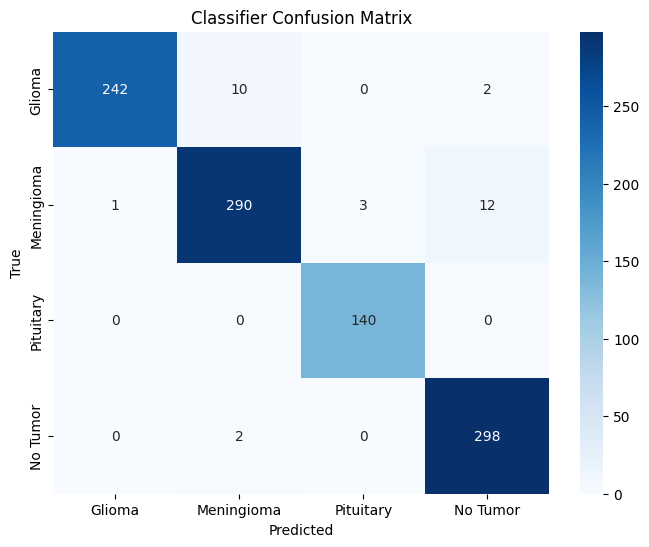

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

def plot_confusion_matrix(model_cls, cls_test_loader, tumor_names, title="Classifier Confusion Matrix"):

    model_cls.eval()
    all_preds, all_labels = [], []
    device = next(model_cls.parameters()).device

    with torch.no_grad():
        for x, y in tqdm(cls_test_loader, desc="Computing Confusion Matrix"):
            if torch.isnan(x).any() or torch.isinf(x).any() or torch.isnan(y).any() or torch.isinf(y).any():
                print("NaN/Inf detected in classification test input or label")
                continue
            x = x.to(device)
            y_pred = model_cls(x)
            preds = y_pred.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())


    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3])


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[tumor_names[i] for i in range(4)],
                yticklabels=[tumor_names[i] for i in range(4)])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


tumor_names = {0: "Glioma", 1: "Meningioma", 2: "Pituitary", 3: "No Tumor"}
plot_confusion_matrix(model_cls, cls_test_loader, tumor_names)


REFERENCES:

1.Medical Image Segmentation Review: The success of U-Net https://arxiv.org/pdf/2211.14830